# References

* https://pangeo-forge.readthedocs.io/en/latest/tutorials/xarray_zarr/netcdf_zarr_sequential.html
* https://github.com/developmentseed/staged-recipes/blob/add/gpm-imerg/recipes/gpm-imerg/gpm-imerg.ipynb
* https://github.com/pangeo-forge/gpm-imerge-hhr-feedstock/blob/main/feedstock/recipe.py

In [1]:
# Create the sample zarr recipe
import aiohttp
import pandas as pd

from pangeo_forge_recipes.patterns import ConcatDim, FilePattern
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

# TODO: replace with ENV vars
username = password = "pangeo@developmentseed.org"

def make_filename(time):
    input_url_pattern = (
        "https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/{yyyy}/{mm}/{dd}/"
        "imerg/3B-HHR.MS.MRG.3IMERG.{yyyymmdd}-S{sh}{sm}00-E{eh}{em}59.{MMMM}.V06B.HDF5"
    ).format(
        yyyy=time.strftime("%Y"),
        mm=time.strftime("%m"),
        dd=time.strftime("%d"),
        yyyymmdd=time.strftime("%Y%m%d"),
        sh=time.strftime("%H"),
        sm=time.strftime("%M"),
        eh=time.strftime("%H"),
        em=(time + pd.Timedelta("29 min")).strftime("%M"),
        MMMM=f"{(time.hour*60 + time.minute):04}",
    )
    return input_url_pattern


dates = pd.date_range("2000-06-01T00:00:00", "2000-06-01T02:00:00", freq="30min")
time_concat_dim = ConcatDim("time", dates, nitems_per_file=1)
pattern = FilePattern(
    make_filename,
    time_concat_dim,
    fsspec_open_kwargs={"auth": aiohttp.BasicAuth(username, password)}
)

recipe = XarrayZarrRecipe(
    pattern,
    xarray_open_kwargs={"group": "Grid", "decode_coords": "all", "engine": "netcdf4" },
    inputs_per_chunk=1,
    copy_input_to_local_file=True,
)

In [2]:
import logging
logger = logging.getLogger("pangeo_forge_recipes")
formatter = logging.Formatter('%(name)s:%(levelname)s - %(message)s')
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
handler.setFormatter(formatter)
logger.setLevel(logging.INFO)
logger.addHandler(handler)

In [3]:
all_inputs = list(recipe.iter_inputs())
print(len(all_inputs))
all_chunks = list(recipe.iter_chunks())
len(all_chunks)

5


5

In [4]:
with recipe.open_chunk(all_chunks[0]) as ds:
    display(ds)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' directly.
pangeo_forge_recipes.storage:INFO - Copying 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' to local file '/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/tmpb52dyjli.HDF5'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0'


<xarray.Dataset>
Dimensions:                         (time: 1, lon: 3600, lat: 1800, nv: 2, lonv: 2, latv: 2)
Coordinates:
  * time                            (time) object 2000-06-01 00:00:00
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (lon, lonv) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
    lat_bnds                        (lat, latv) float32 dask.array<chunksize=(1800, 2), meta=np.ndarray>
Dimensions without coordinates: nv, lonv, latv
Data variables:
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

In [5]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

recipe.input_cache = cache_target
recipe.target = target
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 5}>, inputs_per_chunk=1, target_chunks={}, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fa70e9058b0>, root_path='/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/tmpiaw_99wy'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fa70e9058b0>, root_path='/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/tmpptv32h7c'), metadata_cache=None, cache_inputs=True, copy_input_to_local_file=True, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={'group': 'Grid', 'decode_coords': 'all', 'engine': 'netcdf4'}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

In [6]:
for input_file in recipe.inputs_for_chunk(all_chunks[0]):
    recipe.cache_input(input_file)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-0'
pangeo_forge_recipes.storage:INFO - Caching file 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Copying remote file 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' to cache


In [7]:
with recipe.open_chunk(all_chunks[0]) as ds:
    display(ds)
    # need to load if we want to access the data outside of the context
    ds.load()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' from cache
pangeo_forge_recipes.storage:INFO - Copying 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' to local file '/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/tmppm7z8c3_.HDF5'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0'


<xarray.Dataset>
Dimensions:                         (time: 1, lon: 3600, lat: 1800, nv: 2, lonv: 2, latv: 2)
Coordinates:
  * time                            (time) object 2000-06-01 00:00:00
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (lon, lonv) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
    lat_bnds                        (lat, latv) float32 dask.array<chunksize=(1800, 2), meta=np.ndarray>
Dimensions without coordinates: nv, lonv, latv
Data variables:
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

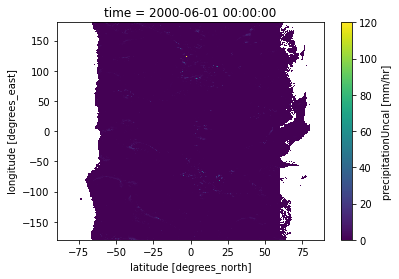

In [8]:
ds.precipitationUncal[0].plot()

In [9]:
recipe.prepare_target()

/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/pangeo_forge_recipes/recipes/xarray_zarr.py:116: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Creating a new dataset in target
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.M

In [10]:
for chunk in recipe.iter_chunks():
    recipe.store_chunk(chunk)
recipe.finalize_target()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5'
pangeo_forge_recipes.storage:INFO - Opening 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' from cache
pangeo_forge_recipes.storage:INFO - Copying 'https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/2000/06/01/imerg/3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B.HDF5' to local file '/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/tmpvlmkrj79.HDF5'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing variable time chunk time-0 to Zarr region (slice(0, 1, None),)
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing varia

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/tmpptv32h7c/1852ad205d3f767c81d6d5bd103a8cb1-https_arthurhouhttps.pps.eosdis.nasa.gov_gpmdata_2000_06_01_imerg_3b-hhr.ms.mrg.3imerg.20000601-s003000-e005959.0030.v06b.hdf5'

In [11]:
import xarray as xr
ds = xr.open_zarr(target_dir.name)

In [12]:
ds

<xarray.Dataset>
Dimensions:                         (time: 1, lon: 3600, lat: 1800, latv: 2, lonv: 2, nv: 2)
Coordinates:
  * lat                             (lat) float32 -89.95 -89.85 ... 89.85 89.95
    lat_bnds                        (lat, latv) float32 dask.array<chunksize=(1800, 2), meta=np.ndarray>
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
    lon_bnds                        (lon, lonv) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
  * time                            (time) object 2000-06-01 00:00:00
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: latv, lonv, nv
Data variables:
    HQobservationTime               (time, lon, lat) timedelta64[ns] dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipSource                  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    IRprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationCal                (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationUncal              (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

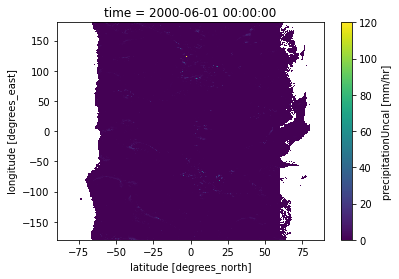

In [13]:
ds.precipitationUncal[0].plot()

In [14]:
ds.precipitationUncal.max().values

array(120., dtype=float32)

In [15]:
from ndpyramid import pyramid_reproject
from carbonplan_data.utils import set_zarr_encoding
from carbonplan_data.metadata import get_cf_global_attrs

/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)


In [38]:
ds_precip = ds.precipitationUncal.to_dataset(name="precipitation").squeeze().reset_coords(["time"], drop=True)
ds_precip

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600)
Coordinates:
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
    spatial_ref    int64 0
Data variables:
    precipitation  (lon, lat) float32 dask.array<chunksize=(3600, 1800), meta=np.ndarray>

In [40]:
# dt = pyramid_reproject(ds_precip, levels=6)
# ?pyramid_reproject
ds_reproj = ds_precip.rio.write_crs("epsg:4326", inplace=True).transpose('lat', 'lon')

In [41]:
ds_reproj

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600)
Coordinates:
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
    spatial_ref    int64 0
Data variables:
    precipitation  (lat, lon) float32 dask.array<chunksize=(1800, 3600), meta=np.ndarray>

In [42]:
dt = pyramid_reproject(ds_reproj, levels=6)

In [43]:
dt.children

(DataNode(name='0', parent='root', children=[],
 data=<xarray.Dataset>
      Dimensions:        (x: 128, y: 128)
      Coordinates:
        * x              (x) float64 -1.987e+07 -1.956e+07 ... 1.956e+07 1.987e+07
        * y              (y) float64 1.989e+07 1.958e+07 ... -1.958e+07 -1.989e+07
          spatial_ref    int64 0
      Data variables:
          precipitation  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
 ),
 DataNode(name='1', parent='root', children=[],
 data=<xarray.Dataset>
      Dimensions:        (x: 256, y: 256)
      Coordinates:
        * x              (x) float64 -1.995e+07 -1.979e+07 ... 1.979e+07 1.995e+07
        * y              (y) float64 1.997e+07 1.981e+07 ... -1.981e+07 -1.997e+07
          spatial_ref    int64 0
      Data variables:
          precipitation  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
 ),
 DataNode(name='2', parent='root', children=[],
 data=<xarray.Dataset>
      Dimensions:        (x: 512, y: 512)
     

In [44]:
# modify the data in the pyramid
for child in dt.children:
    child.ds = set_zarr_encoding(
        child.ds, codec_config={"id": "zlib", "level": 1}, float_dtype="float32"
    )
    child.ds = child.ds.chunk({"x": 128, "y": 128})
    child.ds["precipitation"].attrs.clear()
dt.attrs = get_cf_global_attrs()

In [45]:
save_path = "../data"
dt.to_zarr(save_path + "/gpmimerg.zarr", consolidated=True)